# Warp a Distribution
*This notebook demonstrates how we can warp a normal distribution*

## Import Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston
from scipy.stats import norm
np.random.seed(1)

## Decorator for Vector Functions

In [2]:
def vectorizable(f):
    def f_(x):
        if hasattr(x, '__iter__'):
            return np.array([f(xi) for xi in x])
        return f(x)
    return f_

## Compute Transition Spline
Compute a spline that smoothly transitions between two different linear functions

In [3]:
def compute_spline(fpa, fpb, delta):
    mid = delta / 2
    fpmid = (fpb + fpa) / 2
    b1 = fpa
    d1 = (fpmid - b1)/(3*mid**2)
    
    def q1(x):
        return b1*x + d1*x**3
    def q1p(x):
        return b1 + 3*d1*x**2

    qmid = q1(mid)
    
    b2 = fpb
    d2 = (fpmid - b2) / (3*mid**2)
    a2 = qmid + b2*mid + d2*mid**3
    
    def q2(x):
        return a2 + b2*(x - delta) + d2*(x - delta)**3
    def q2p(x):
        return b2 + 3*d2*(x - delta)**2
    
    def q(x):
        if x < mid:
            return q1(x)
        return q2(x)
    def qp(x):
        if x < mid:
            return q1p(x)
        return q2p(x)
    return q, qp

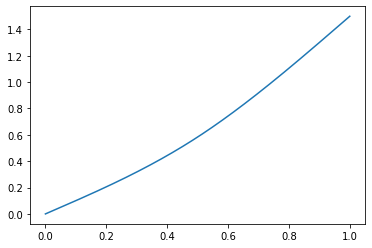

In [4]:
q, qp = compute_spline(1, 2, 1)
x = np.arange(0, 1, .0001)
y = [q(xi) for xi in x]
plt.plot(x, y)

## Build a Warping Function
Using the spline, construct a warping function and its derivative 

In [5]:
def make_warp(descriptor, delta=0.5):
    slope = descriptor[0]
    rest = descriptor[1:]
    if not rest:
        return lambda x: x*slope, lambda x: slope
    z, rslope = rest[0]
    r, rp = make_warp([rslope] + rest[1:], delta)
    c = (rslope - slope) / (2 * delta)
    intercept = slope*z + c*delta - r(z)
    q, qp = compute_spline(slope, rslope, delta)
    @vectorizable
    def f(x):
        if x < z - delta:
            return slope * x
        if x > z:
            return r(x) + intercept
        return q(x - (z-delta))+slope*(z - delta)
    @vectorizable
    def fp(x):
        if x < z - delta:
            return slope
        if x > z:
            return rp(x)
        return qp(x - (z-delta))
    return f, fp

## Make Hinge Warping Functions

In [6]:
def make_hinge(slope):
    return make_warp([1, (1, slope)], 1)

In [7]:
slopes = [2.0, 1.0, 0.5]

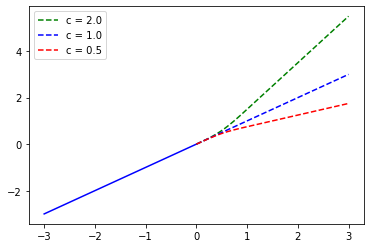

In [8]:
x = np.arange(-3, 3, 0.0001)
colors = ['g', 'b', 'r']
fig, ax = plt.subplots()
ax.plot(x, [xi if xi < 0 else None for xi in x], c='b', label='')
for i, slope in enumerate(slopes):
    f, _ = make_hinge(slope)
    y = [f(xi) if xi > 0 else None for xi in x]
    ax.plot(x, y, linestyle='dashed', c=colors[i], label='c = %0.1f' % slope)
ax.legend(loc='upper left')
plt.show()

## Plot Hinge Distributions

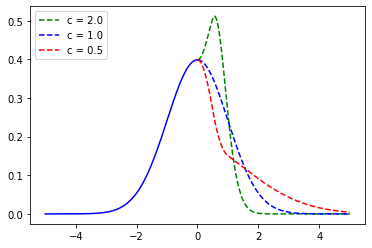

In [9]:
x = np.arange(-5, 5, 0.0001)
colors = ['g', 'b', 'r']
fig, ax = plt.subplots()
ax.plot(x, [norm.pdf(xi) if xi < 0 else None for xi in x], c='b', label='')
for i, slope in enumerate(slopes):
    f, fp = make_hinge(slope)
    y = [norm.pdf(f(xi))*fp(xi) if xi > 0 else None for xi in x]
    ax.plot(x, y, linestyle='dashed', c=colors[i], label='c = %0.1f' % slope)
ax.legend(loc='upper left')
plt.show()